In [3]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Helpers

In [4]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [5]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

# for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
#     for dl_path in files:
#         logging.info("downloading & extracting file %s", dl_path)
#         archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
#         download_file(dl_path, archive_path)
#         extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

#  UPDATE Method call : added sort=False to avoid future version Warning
df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True,sort=False)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True,sort=False)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:52298 matches ATP in df_atp
INFO:root:29581 matches WTA in df_wta


## Your work

## Questions

### 1. Who are the three ATP players with the most wins ?

In [7]:
df_atp['Winner'].value_counts().head(3)

Federer R.     1121
Nadal R.        891
Djokovic N.     802
Name: Winner, dtype: int64

### 2. How many sets did the player “Federer R.” win in total ? 

In [8]:
#Take loser into account to count the sets that Federer won but lost the game

federer_sets = df_atp.loc[(df_atp['Winner']=='Federer R.') | (df_atp['Loser'] == 'Federer R.')] 
federer_sets['Wsets'].value_counts().sum() + federer_sets['Lsets'].value_counts().sum()

2682

### 3. How many sets did the player “Federer R.” win during the years 2016 and 2017 ?

In [9]:
federer_2016_17 = federer_sets.loc[(federer_sets['Date'].dt.year == 2016) | (federer_sets['Date'].dt.year == 2017)]
federer_2016_17['Wsets'].value_counts().sum() + federer_2016_17['Lsets'].value_counts().sum()

170

### 4. For each match, what is the percentage of victories of the winner in the past ?

In [14]:

def all_victory_percentages(player_name):
    player_record = df_atp.loc[(df_atp['Winner'] == player_name) | (df_atp['Loser'] == player_name)]
    player_record = player_record.filter(['ATP', 'Date', 'Winner', 'Loser'])
    victory_percentages = list()

    for index, row in player_record.iterrows():
        player_latest_victories = player_record.loc[(player_record['Winner'] == player_name) &
                                              (player_record['Date']<row.Date)]
        
        games_played_till_now = player_record.loc[player_record['Date']<row.Date]
        
        current_victory_percentage = (player_latest_victories.ATP.count() /games_played_till_now.ATP.count()) * 100
        victory_percentages.append(current_victory_percentage)
    
    return victory_percentages

In [42]:
fed_perc = all_victory_percentages('Federer R.')
fed_perc

/home/devendra/myinstallations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


[nan,
 nan,
 50.0,
 33.33333333333333,
 33.33333333333333,
 33.33333333333333,
 50.0,
 50.0,
 50.0,
 50.0,
 50.0,
 63.63636363636363,
 63.63636363636363,
 63.63636363636363,
 64.28571428571429,
 64.28571428571429,
 64.28571428571429,
 64.28571428571429,
 66.66666666666666,
 66.66666666666666,
 65.0,
 61.904761904761905,
 59.09090909090909,
 56.52173913043478,
 54.166666666666664,
 52.0,
 52.0,
 52.0,
 52.0,
 55.172413793103445,
 55.172413793103445,
 55.172413793103445,
 56.25,
 54.54545454545454,
 52.94117647058824,
 51.42857142857142,
 50.0,
 48.64864864864865,
 47.368421052631575,
 47.368421052631575,
 47.368421052631575,
 48.78048780487805,
 48.78048780487805,
 48.78048780487805,
 48.78048780487805,
 51.11111111111111,
 51.11111111111111,
 51.11111111111111,
 51.11111111111111,
 51.11111111111111,
 54.0,
 54.0,
 53.84615384615385,
 53.84615384615385,
 53.70370370370371,
 52.72727272727272,
 52.72727272727272,
 52.63157894736842,
 52.63157894736842,
 52.63157894736842,
 53.3333333333

### Let's Plot it....

<IPython.core.display.Javascript object>


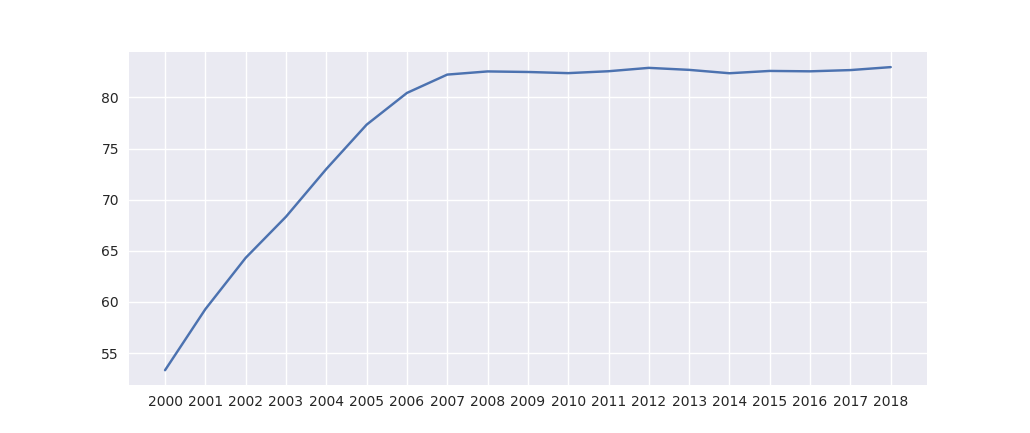

In [16]:
%matplotlib notebook

#create a separate dataframe for plotting by taking year-wise average of previous victory percentages 
player_name = 'Federer R.'
player_record = df_atp.loc[(df_atp['Winner'] == player_name) | (df_atp['Loser'] == player_name)]
player_record = player_record.filter(['ATP', 'Date', 'Winner', 'Loser'])
plot_data = player_record

plot_data['Year'] = player_record['Date'].dt.year
plot_data['previous_victory_percentages'] = fed_perc

plot_data = plot_data.groupby(['Year'],as_index=False).mean()
plot_data.filter(['Year', 'previous_victory_percentages'])

plt.xticks(plot_data['Year'])
plt.plot(plot_data['Year'], plot_data['previous_victory_percentages'])


## Random Forest

## We'll take the following Feature 

* ATP = Tournament number (men)
* WTA = Tournament number (women)
* Location = Venue of tournament
* Tournament = Name of tounament (including sponsor if relevant)
* Data = Date of match (note: prior to 2003 the date shown for all matches played in a single tournament is the start date)
* Series = Name of ATP tennis series (Grand Slam, Masters, International or International Gold)
* Tier = Tier (tournament ranking) of WTA tennis series.
* Court = Type of court (outdoors or indoors)
* Surface = Type of surface (clay, hard, carpet or grass)
* Round = Round of match
* Best of = Maximum number of sets playable in match
* Winner = Match winner
* Loser = Match loser
* WRank = ATP Entry ranking of the match winner as of the start of the tournament
* LRank = ATP Entry ranking of the match loser as of the start of the tournament
* WPts = ATP Entry points of the match winner as of the start of the tournament
* LPts = ATP Entry points of the match loser as of the start of the tournament
* W1 = Number of games won in 1st set by match winner
* L1 = Number of games won in 1st set by match loser
* W2 = Number of games won in 2nd set by match winner
* L2 = Number of games won in 2nd set by match loser
* W3 = Number of games won in 3rd set by match winner
* L3 = Number of games won in 3rd set by match loser
* W4 = Number of games won in 4th set by match winner
* L4 = Number of games won in 4th set by match loser
* W5 = Number of games won in 5th set by match winner
* L5 = Number of games won in 5th set by match loser
* Wsets = Number of sets won by match winner
* Lsets = Number of sets won by match loser
* Comment = Comment on the match (Completed, won through retirement of loser, or via Walkover)

## <font color='red'> And ignore all the ones below </font>


**Key to match betting odds data:**

* B365W = Bet365 odds of match winner
* B365L = Bet365 odds of match loser
* B&WW = Bet&Win odds of match winner
* B&WL = Bet&Win odds of match loser
* CBW = Centrebet odds of match winner
* CBL = Centrebet odds of match loser
* EXW = Expekt odds of match winner
* EXL = Expekt odds of match loser
* LBW = Ladbrokes odds of match winner
* LBL = Ladbrokes odds of match loser
* GBW = Gamebookers odds of match winner
* GBL = Gamebookers odds of match loser
* IWW = Interwetten odds of match winner
* IWL = Interwetten odds of match loser
* PSW = Pinnacles Sports odds of match winner
* PSL = Pinnacles Sports odds of match loser
* SBW = Sportingbet odds of match winner
* SBL = Sportingbet odds of match loser
* SJW = Stan James odds of match winner
* SJL = Stan James odds of match loser
* UBW = Unibet odds of match winner
* UBL = Unibet odds of match loser

In [17]:
X= df_atp.filter(['ATP','Tournament','Date','Series','Court','Surface','Round','Best of','Loser',
                    'WRank','LRank',
                    'WPts','LPts ',
                    'W1','L1',
                    'W2','L2',
                    'W3','L3',
                    'W4','L4',
                    'W5','L5',
                    'Wsets','Lsets',
                    'Comment'])
Y = df_atp.filter(['Winner'])

In [18]:
Y.describe()

,Winner
count,52298
unique,948
top,Federer R.
freq,1121


### Cleaning Data

In [19]:
# Label Encoding the categorical data
le = preprocessing.LabelEncoder()
le.fit(Y['Winner'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{' Hajek J.': 0, 'Abel M.': 1, 'Acasuso J.': 2, 'Agassi A.': 3, 'Agenor R.': 4, 'Aguilar J.': 5, 'Ahouda A.': 6, 'Al Ghareeb M.': 7, 'Alami K.': 8, 'Albot R.': 9, 'Aldi F.': 10, 'Allegro Y.': 11, 'Almagro N.': 12, 'Alonso J.': 13, 'Altmaier D.': 14, 'Alund M.': 15, 'Alvarez E.': 16, 'Alves T.': 17, 'Amritraj P.': 18, 'Ancic I.': 19, 'Ancic M.': 20, 'Andersen J.F.': 21, 'Anderson K.': 22, 'Andreev I.': 23, 'Andreozzi G.': 24, 'Andujar P.': 25, 'Arazi H.': 26, 'Arguello F.': 27, 'Armando H.': 28, 'Arnaboldi A.': 29, 'Arthurs W.': 30, 'Ascione A.': 31, 'Ascione T.': 32, 'Auckland J.': 33, 'Auger-Aliassime F.': 34, 'Baccanello P.': 35, 'Bachelot J.F': 36, 'Bachinger M.': 37, 'Baghdatis M.': 38, 'Bagnis F.': 39, 'Bai Y.': 40, 'Baker B.': 41, 'Baker J.': 42, 'Balazs A.': 43, 'Balcells J.': 44, 'Ball C.': 45, 'Balleret B.': 46, 'Barton M.': 47, 'Basic M.': 48, 'Basilashvili N.': 49, 'Bastl G.': 50, 'Bautista Agut R.': 51, 'Bautista R.': 52, 'Beck A.': 53, 'Beck K.': 54, 'Becker B.': 55, 'Bede

In [20]:
le.transform(Y['Winner'])

array([210, 231, 235, ..., 939, 201, 939])

In [24]:

def encode_multiple_columns(column_names):
    for name in column_names:
        le.fit(X[name])
        le.transform(X[name])

def fill_empty_values(column_names):
    for name in column_names:
        X[name] = X[name].replace(r'\s+', np.nan, regex=True)
        X[name] = X[name].fillna(0)
        X[name] = pd.to_numeric(X[name])
        X[name] = X[name].astype(np.float32)

def fill_empty_special(column_names):
    """
    Method for columns with an extra value 'NR' other than NaN
    """
    for name in column_names:
        X[name] = X[name].replace(r'\s+', np.nan, regex=True)
        X[name] = X[name].replace('NR', np.nan, regex=True)
        X[name] = X[name].fillna(0)
        X[name] =pd.to_numeric(X[name])
        X[name] = X[name].astype(np.float32)

In [25]:
# Manual correction of exceptional entries
X.Lsets.values[18827] = 1 #Original Value = '`1'

In [27]:
columns_to_encode = ['Tournament','Surface','Court','Comment','Series','Round','Loser']
encode_multiple_columns(columns_to_encode)

columns_with_empty_cells = ['W1','L1','W2','L2','W3','L3','W4','L4','W5','L5','Wsets','Lsets']
fill_empty_values(columns_with_empty_cells)

columns_with_NR_value = ['WRank','LRank','WPts']
fill_empty_special(columns_with_NR_value)

# fill_empty_special('WPts')

In [28]:
# For some reason the method doesn't work for X['WPts'] 
# TO DO : debug to use utility method fill_empty_special() for this as well
    
X['WPts'] = X['WPts'].replace(r'\s+', np.nan, regex=True)
X['WPts'] = X['WPts'].fillna(0)
X['WPts'] = pd.to_numeric(X['WPts'])
X['WPts'] = X['WPts'].astype(np.float32)

In [29]:
X['WPts'].unique()

array([   0., 1425.,    9., ..., 5085., 8045., 6020.])

In [30]:
#Factorise all string values to some integer value for RandomForest to Run

char_cols = X.dtypes.pipe(lambda x: x[x == 'object']).index
for c in char_cols:
    X[c] = pd.factorize(X[c])[0]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=66)

#Dropping Feature : Date for baseline model
X_train = X_train.drop(['Date'],axis=1)
X_test = X_test.drop(['Date'],axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35039 entries, 9031 to 25620
Data columns (total 24 columns):
ATP           35039 non-null int64
Tournament    35039 non-null int64
Series        35039 non-null int64
Court         35039 non-null int64
Surface       35039 non-null int64
Round         35039 non-null int64
Best of       35039 non-null int64
Loser         35039 non-null int64
WRank         35039 non-null float32
LRank         35039 non-null float32
WPts          35039 non-null float32
W1            35039 non-null float32
L1            35039 non-null float32
W2            35039 non-null float32
L2            35039 non-null float32
W3            35039 non-null float32
L3            35039 non-null float32
W4            35039 non-null float32
L4            35039 non-null float32
W5            35039 non-null float32
L5            35039 non-null float32
Wsets         35039 non-null float32
Lsets         35039 non-null float32
Comment       35039 non-null int64
dtypes: float32(15

In [38]:
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=66)
rfc = RandomForestClassifier()

rfc.fit(X_train,y_train)

/home/devendra/myinstallations/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [39]:
rfc.score(X_train,y_train)

0.9962327692000342

In [40]:
rfc.score(X_test,y_test)

0.10545222782316473